In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean

In [3]:
sample_size, val_size, test_size = 300, 100, 100

x_train = tf.random.normal(shape = (sample_size, 1), dtype = tf.float32)
x_train_noise = x_train + 0.2*tf.random.normal(shape = (sample_size, 1))
y_train = tf.cast((x_train_noise > 0), dtype = tf.int32)

x_val = tf.random.normal(shape = (val_size, 1), dtype = tf.float32)
x_val_noise = x_val + 0.2*tf.random.normal(shape = (val_size, 1))
y_val = tf.cast((x_val_noise > 0), dtype = tf.int32)

x_test = tf.random.normal(shape = (test_size, 1), dtype = tf.float32)
x_test_noise = x_test + 0.2*tf.random.normal(shape = (test_size, 1))
y_test = tf.cast((x_test_noise > 0), dtype = tf.int32)

2022-01-16 23:41:20.693331: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


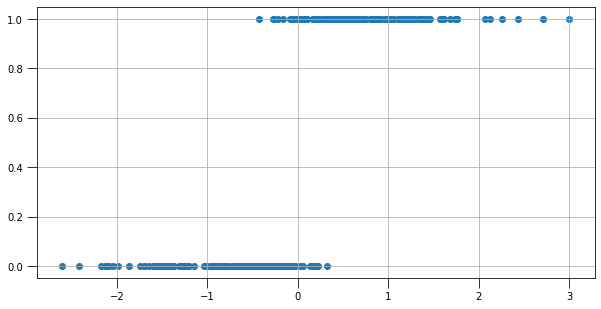

In [4]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.scatter(x_train, y_train)
ax.tick_params(size = 10)
ax.grid()

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(sample_size).batch(6)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(val_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(test_size)

In [6]:
model = Sequential()
model.add(Dense(units = 2, activation = 'softmax'))

In [7]:
loss_object = SparseCategoricalCrossentropy()
optimizer = SGD(learning_rate = 1)

train_loss = Mean()
train_acc = SparseCategoricalAccuracy()

val_loss = Mean()
val_acc = SparseCategoricalAccuracy()

test_loss = Mean()
test_acc = SparseCategoricalAccuracy()

EPOCHS = 10

In [8]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []

In [9]:
@tf.function # Accelerate the speed of function
def train():
    global train_dataset, model, loss_object
    global train_loss, train_acc
        
    for x, y in train_dataset:
        with tf.GradientTape() as tape:
            predictions = model(x)
            loss = loss_object(y, predictions)
            
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        train_loss(loss)
        train_acc(y, predictions)

In [10]:
@tf.function
def validation():
    global val_dataset, model, loss_object
    global val_loss, val_acc
    
    for x, y in val_dataset:
        predictions = model(x)
        loss = loss_object(y, predictions)
        
        val_loss(loss)
        val_acc(y, predictions)
        

In [11]:
def train_reporter():
    global epoch, train_loss, train_acc
    global val_loss, val_acc
    
    print('Epoch:', epoch, 'Train loss: {:.4f}\t Train accuracy: {:.2f}%\n'.format(train_loss.result(), train_acc.result()*100))
    print('Validation loss: {:.4f}\t Validation accuracy: {:.2f}%\n'.format(val_loss.result(), val_acc.result()*100))

In [12]:
def metric_resetter():
    global train_loss, train_acc
    global val_loss, val_acc
    
    train_losses.append(train_loss.result())
    train_accs.append(train_acc.result())
    val_losses.append(val_loss.result())
    val_accs.append(val_acc.result())
    
    train_loss.reset_states()
    train_acc.reset_states()
    val_loss.reset_states()
    val_acc.reset_states()

In [13]:
def final_result_visualization():
    global train_losses, train_accs
    global val_losses, val_accs
    
    fig, axes = plt.subplots(2, 1, figsize = (20, 15))
    axes[0].plot(train_losses, label = 'Train Loss')
    axes[0].plot(val_losses, label = 'Validation Loss')
    
    axes[1].plot(train_accs, label = 'Train Accuracy')
    axes[1].plot(val_accs, label = 'Validation Accuracy')
    
    axes[0].tick_params(labelsize = 20)
    axes[1].tick_params(labelsize = 20)
    
    axes[0].set_ylabel('Binary Cross Entropy', fontsize = 20)
    axes[1].set_ylabel('Accuracy', fontsize = 20)
    axes[1].set_xlabel('Epoch', fontsize = 20)
    
    axes[0].legend(loc = 'upper right', fontsize = 20)
    axes[1].legend(loc = 'lower right', fontsize = 20)

In [14]:
for epoch in range(EPOCHS):
    train()
#     for x, y in train_dataset:
#         with tf.GradientTape() as tape:
#             predictions = model(x)
#             loss = loss_object(y, predictions)
            
#         gradients = tape.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
#         train_loss(loss)
#         train_acc(y, predictions)
        
    validation()
#     for x, y in val_dataset:
#         predictions = model(x)
#         loss = loss_object(y, predictions)
        
#         val_loss(loss)
#         val_acc(y, predictions)
        
    train_reporter()
#     print('Epoch:', epoch, 'Train loss: {:.4f}\t Train accuracy: {:.2f}%\n'.format(train_loss.result(), train_acc.result()*100))
#     print('Validation loss: {:.4f}\t Validation accuracy: {:.2f}%\n'.format(val_loss.result(), val_acc.result()*100))

    metric_resetter()
#     train_losses.append(train_loss.result())
#     train_accs.append(train_acc.result())
#     val_losses.append(val_loss.result())
#     val_accs.append(val_acc.result())

#     train_loss.reset_states()
#     train_acc.reset_states()
#     val_loss.reset_states()
#     val_acc.reset_states()

Epoch: 0 Train loss: 0.1976	 Train accuracy: 94.00%

Validation loss: 0.1387	 Validation accuracy: 94.00%

Epoch: 1 Train loss: 0.1633	 Train accuracy: 94.67%

Validation loss: 0.1277	 Validation accuracy: 95.00%

Epoch: 2 Train loss: 0.1629	 Train accuracy: 93.67%

Validation loss: 0.1280	 Validation accuracy: 95.00%

Epoch: 3 Train loss: 0.1546	 Train accuracy: 94.00%

Validation loss: 0.1347	 Validation accuracy: 94.00%

Epoch: 4 Train loss: 0.1541	 Train accuracy: 93.33%

Validation loss: 0.1331	 Validation accuracy: 94.00%

Epoch: 5 Train loss: 0.1566	 Train accuracy: 94.33%

Validation loss: 0.1274	 Validation accuracy: 95.00%

Epoch: 6 Train loss: 0.1570	 Train accuracy: 93.67%

Validation loss: 0.1293	 Validation accuracy: 95.00%

Epoch: 7 Train loss: 0.1540	 Train accuracy: 94.00%

Validation loss: 0.1279	 Validation accuracy: 95.00%

Epoch: 8 Train loss: 0.1533	 Train accuracy: 93.67%

Validation loss: 0.1309	 Validation accuracy: 95.00%

Epoch: 9 Train loss: 0.1508	 Train ac

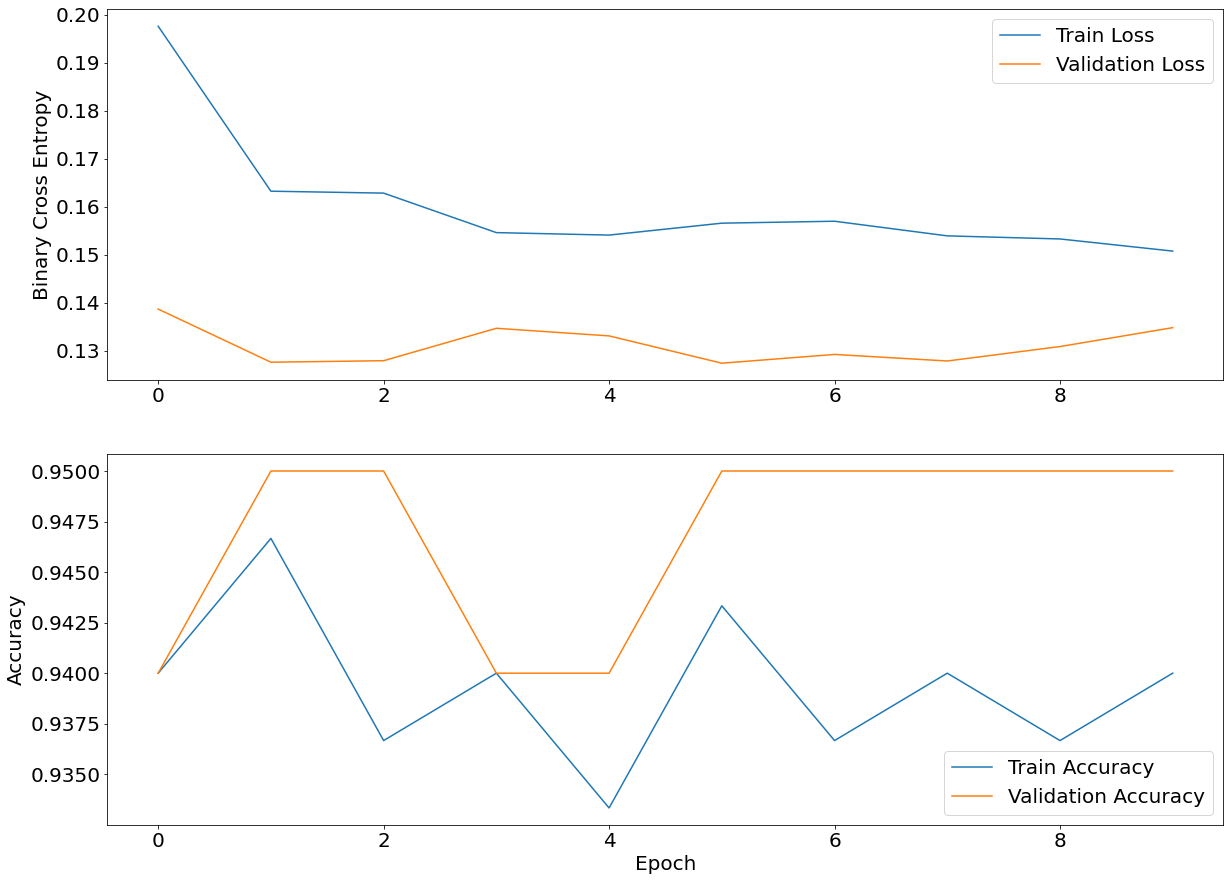

In [15]:
final_result_visualization()

In [16]:
for x, y in test_dataset:
    predictions = model(x)
    loss = loss_object(y, predictions)
        
    test_loss(loss)
    test_acc(y, predictions)  

print('Test loss: {:.4f}\t Test accuracy: {:.2f}%\n'.format(test_loss.result(), test_acc.result()*100))

Test loss: 0.2091	 Test accuracy: 89.00%

